In [63]:
#!pip3 install torch torchvision

In [64]:
import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import os
import matplotlib.pyplot as plt

# Check for MPS availability
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("MPS device not found. Using CPU")

Using MPS (Metal Performance Shaders) device


In [65]:
# Class names
class_names = ['non-skin', 'skin']
# Paths to your model and test images
model_path = '../weights/skin_non_skin_model_mps.pth'  # Replace with your model path
test_dir = 'testing_img/'  # Replace with your test images directory

# Load pre-trained MobileNetV2 model with updated weights argument
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

# Modify the classifier
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)

# Load the saved model weights
model.load_state_dict(torch.load(model_path, map_location=device))

# Move model to device
model = model.to(device)
model.eval()  # Set model to evaluation mode

/var/folders/t2/924llr7552s5t3whlr5cww8c0000gn/T/ipykernel_25608/319353335.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, 

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [66]:
# Define image transformations (should match training preprocessing)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [67]:
def predict_and_display(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image)
    input_batch = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_batch)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        _, pred = torch.max(output, 1)
        prediction = class_names[pred.item()]
        confidence = probabilities[pred.item()].item() * 100
    
    # Display the image and prediction
    plt.imshow(image)
    plt.title(f'Prediction: {prediction} ({confidence:.2f}%)')
    plt.axis('off')
    plt.show()

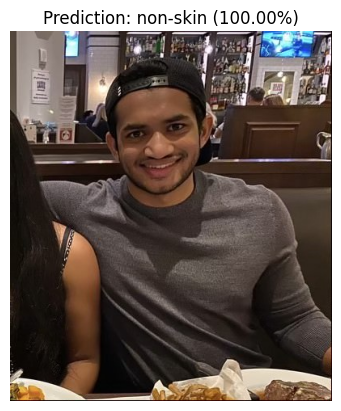

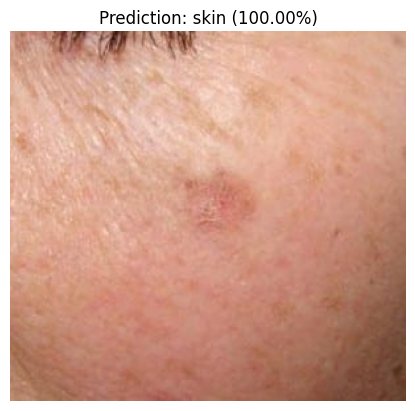

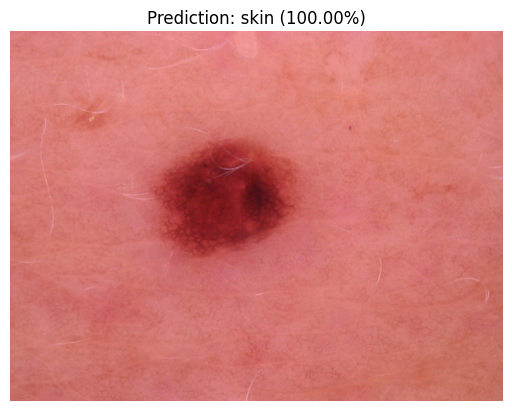

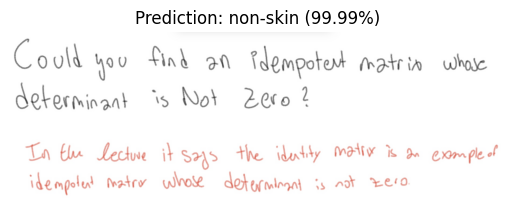

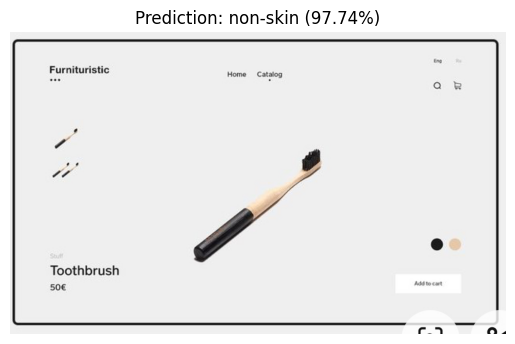

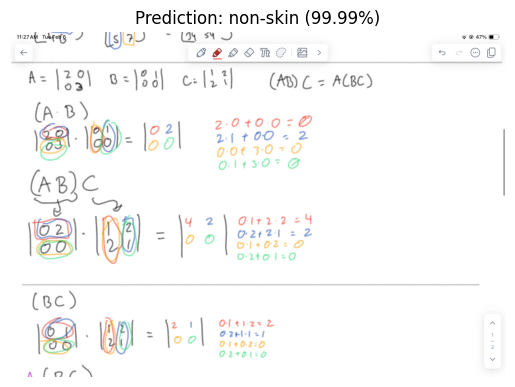

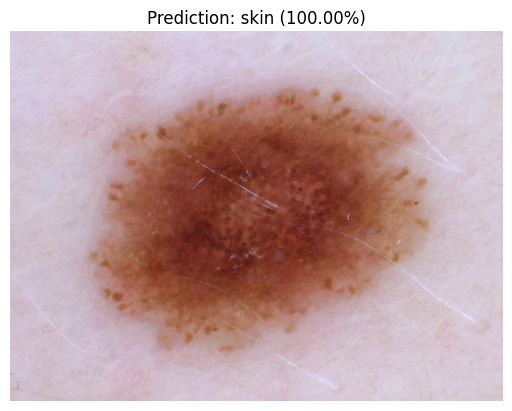

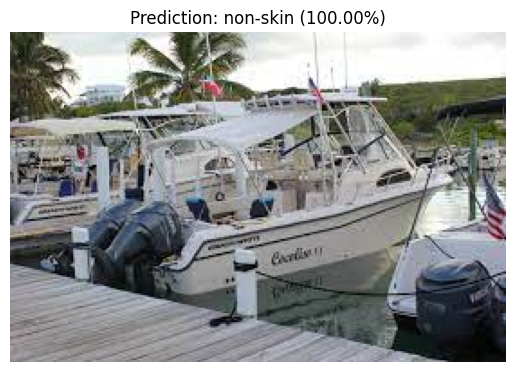

In [68]:
# Get list of image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]

if not image_files:
    print(f'No image files found in {test_dir}')
else:
    for image_name in image_files:
        image_path = os.path.join(test_dir, image_name)
        predict_and_display(image_path)